# 1. A warm-up case

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess

In [60]:
x = np.array([[1,3,5,6,7,8]]).T

In [61]:
y = (x * np.sin(x)).ravel() # x * np.sin(x) means the elementary multiplication
y

array([ 0.84147098,  0.42336002, -4.79462137, -1.67649299,  4.59890619,
        7.91486597])

In [62]:
gp = GaussianProcess(theta0=0.1, thetaL=.001, thetaU=1.)

f:\python\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)


In [63]:
gp.fit(x,y)

f:\python\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x00000270957E4EA0>,
        normalize=True, nugget=array(2.220446049250313e-15),
        optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x0000027094CB2EE8>,
        regr=<function constant at 0x00000270957E4BF8>,
        storage_mode='full', theta0=array([[ 0.1]]),
        thetaL=array([[ 0.001]]), thetaU=array([[ 1.]]), verbose=False)

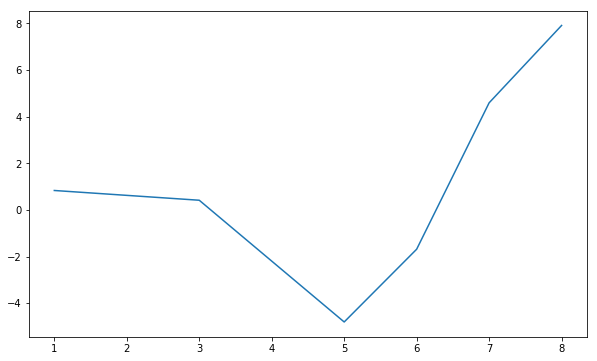

In [57]:
plt.plot(x,y)
plt.fill(np.concatenate(x,x[::-1])), y
plt.show()

# 2. Example - Finding the Maximum Value of a Function

Here we show a simple case of implementing bayesian optimization to find the minimum of a function.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
from scipy.stats import norm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(7)

Then we build the acquisition functions.

In [15]:
def probability_of_improvement(mu, sigma, opt_value, error = 0.5):
    gamma = (opt_value - mu - error)/sigma
    return norm.cdf(gamma)

def expected_improvement(mu, sigma, opt_value, error = 0.5):
    gamma = (opt_value - mu - error)/sigma
    return sigma*(gamma*norm.cdf(gamma) + norm.pdf(gamma))

def GP_UCB(mu, sigma, opt_value, K = 1.0):
    return mu + K*sigma

Here we suggest f(x) to be the true unknown function we want to approximate. We then add some noise to f(x).

In [16]:
noise_level = 0.1

def f(x): # The true function
    return (np.sin(5 * x) * (1 - np.tanh(x ** 2))).ravel()

def noise_f(x, sigma=noise_level): # Add some noise
    return f(x) + np.random.randn(len(x)) * sigma

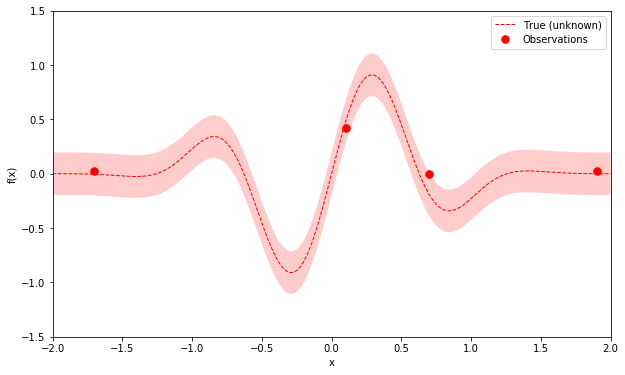

In [29]:
x = np.linspace(-2, 2, 400)
plt.plot(x, f(x), "r--", label="True (unknown)", linewidth = 1)
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([f(x) - 1.9600 * noise_level, (f(x) + 1.9600 * noise_level)[::-1]]),
         alpha=0.2, fc='r', ec='None')

xi = np.array([-1.7, 0.1, 0.7, 1.9]).reshape(-1, 1)
yi = noise_f(xi)
plt.plot(xi.ravel(), yi, "r.", markersize=15, label="Observations")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.ylim(-1.5, 1.5)
plt.xlim(-2, 2)
plt.legend(loc="best")
plt.savefig("fig1.pdf")
plt.show()

Then we create a function which draws the process of approaching the optimum.

In [32]:
def plot(xi, yi, gp, acq=None, next_x=None, sharey=True, filename=None):
    x = np.linspace(-2, 2, 400)
    y_pred, sigma = gp.predict(x[:, None], return_std=True) # x[:,None] change the shape of x from (400,) to (400,1)

    plt.plot(x, f(x), "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([f(x) - 1.9600 * noise_level, (f(x) + 1.9600 * noise_level)[::-1]]),
             alpha=.2, fc='r',ec='None', label = 'True CI') # alpha means the extend of the color's darkness, fc means color

    plt.plot(xi, yi, "r.", markersize=15, label="Observations")
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc='g', ec='None', label='Estimated CI') # fc means color
    
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-1.5, 1.5)
    plt.xlim(-2, 2)
    
    if not sharey:
        plt.legend(loc="best")
    
    if acq:
        if not sharey:
            plt.twinx()
            plt.ylabel("u(x)")
        
        plt.plot(x, acq(y_pred, sigma, yi.max()), "b", label="u(x)")
      
        if next_x:
            y_pred, sigma = gp.predict(next_x[:, None], return_std=True) 
            plt.plot([next_x], acq(y_pred, sigma, yi.max()), "b.", markersize=15)
            plt.title(r"$x_t^+ = %.4f$" % xi[np.argmax(yi)])

    if sharey:
        plt.legend(loc="best")
            
    if filename:
        plt.savefig(filename)
        
    plt.show()

Here we implement kernels in Gaussian Process. The main usage of a Kernel is to compute the GP’s covariance between datapoints.

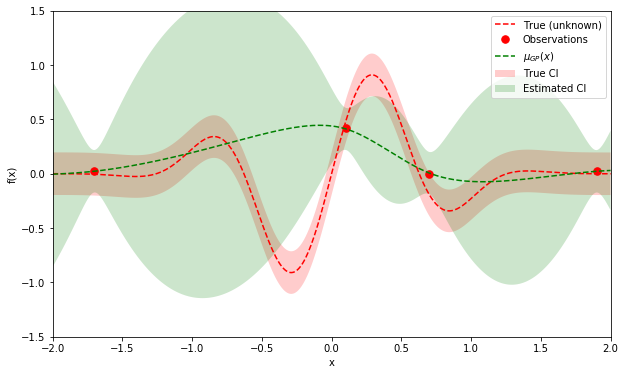

In [33]:
kernel = Matern(length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level**2, random_state=0)
gp.fit(xi, yi)

plot(xi, yi, gp, filename="fig2.pdf")

UCB:


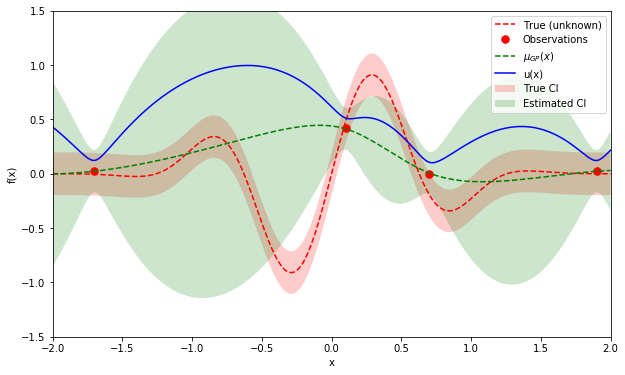

EI:


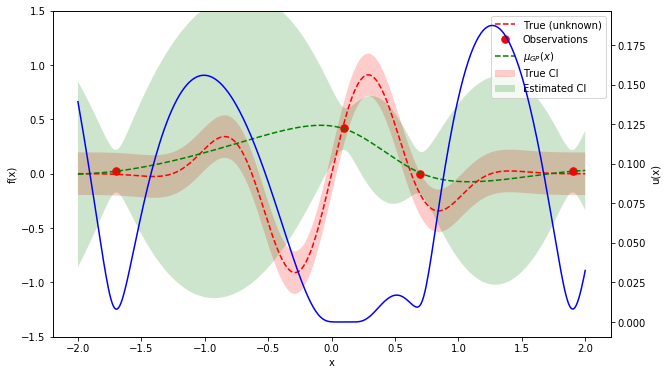

PI:


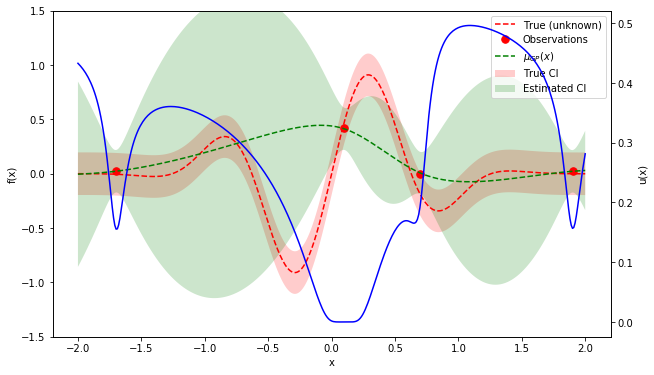

In [34]:
print("UCB:")
plot(xi, yi, gp, acq=GP_UCB, filename="fig3-ucb.pdf")

print("EI:")
plot(xi, yi, gp, acq=expected_improvement, sharey=False, filename="fig3-ei.pdf")

print("PI:")
plot(xi, yi, gp, acq=probability_of_improvement, sharey=False, filename="fig3-pi.pdf")

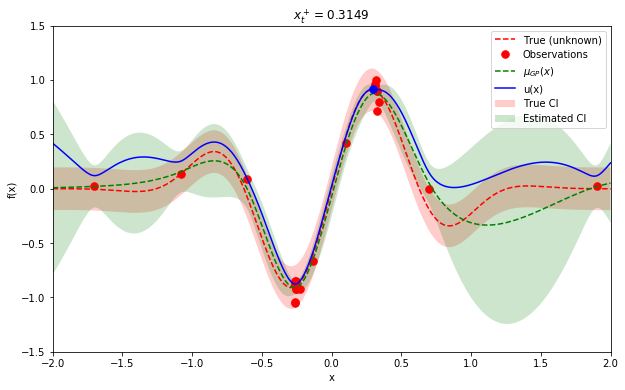

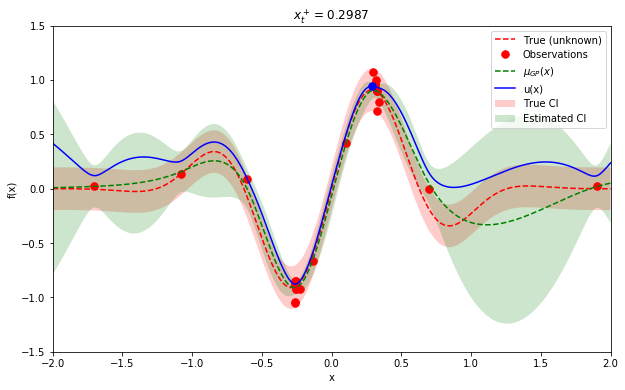

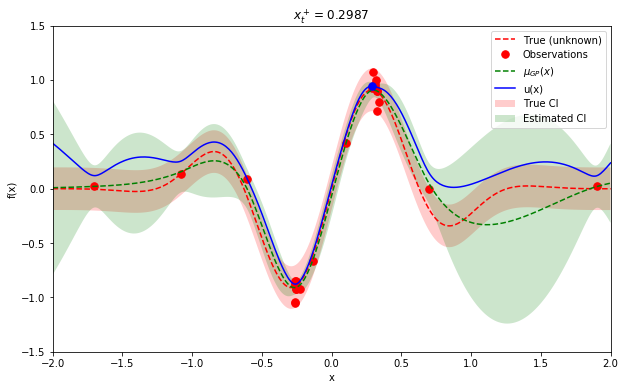

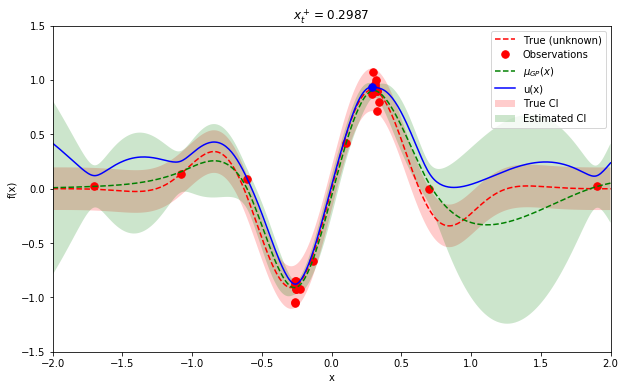

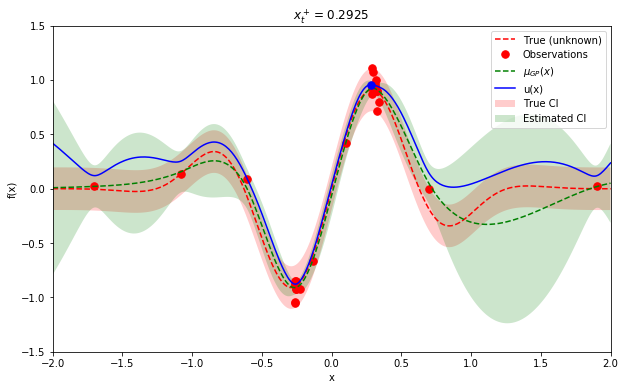

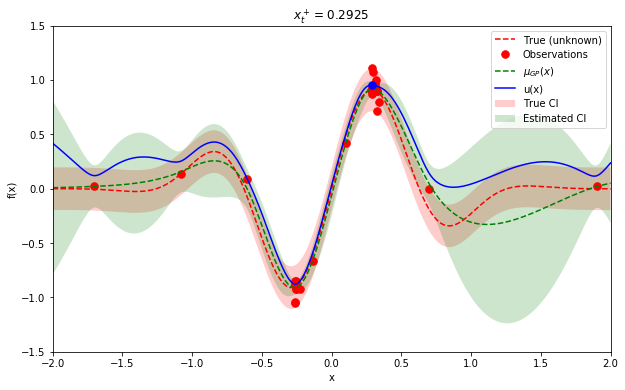

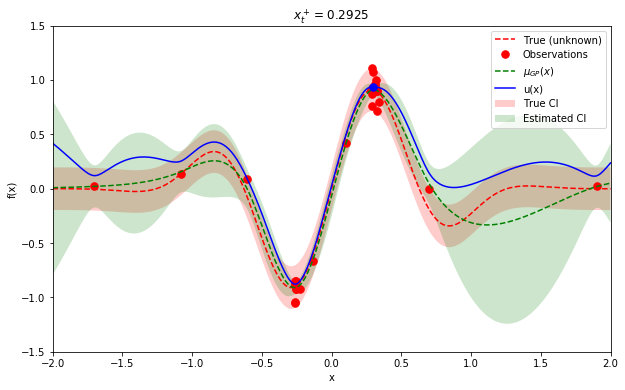

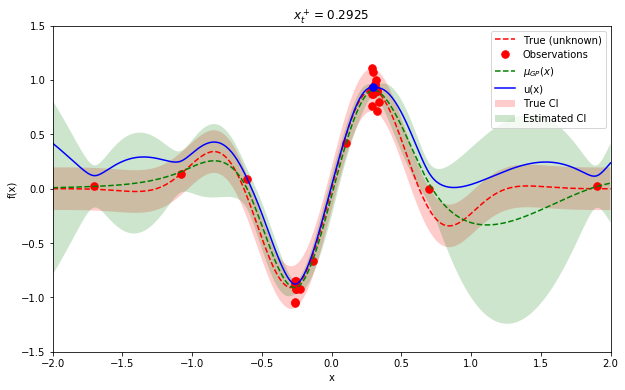

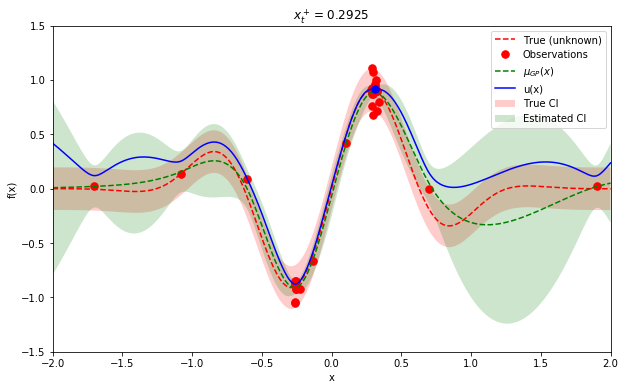

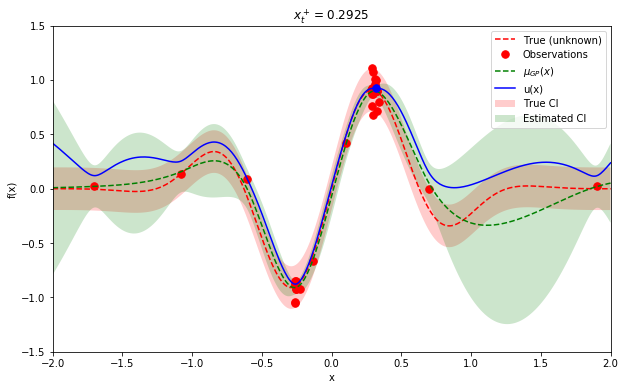

In [37]:
from scipy.optimize import minimize

acq = GP_UCB

def query(xi, yi, gp):
    best_value = np.inf

    for x0 in np.linspace(-2, 2, 10):
        def obj(x):
            x = np.array(x).reshape(1, 1)
            mu_x, sigma_x = gp.predict(x, return_std=True)
            return -acq(mu_x, sigma_x, np.max(yi))

        res = minimize(obj, x0, bounds=[(-2, 2)])

        if res.fun < best_value:
            best_value = res.fun
            query_point = res.x

    return query_point

for i in range(10):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level**2, random_state=0)
    gp.fit(xi, yi)
    
    next_x = query(xi, yi, gp)
    plot(xi, yi, gp, acq=acq, next_x=next_x, filename="fig4-%d.pdf" % i)
    
    xi = np.vstack((xi, next_x))
    yi = np.concatenate((yi, noise_f(xi[-1])))

In [38]:
xi[np.argmax(yi)], np.max(yi)

(array([ 0.29249275]), 1.1122013960271022)

# 3. Tune the Neural Network

We should choose the next point x where the mean is high(exploitation, when you want to work out the maximum of a function) and the variance is high(exploration). This is the trade-off in Bayesian Optimization.

We could balance this tradeoff with an acquisition function as follows: $\mu(x) + K\sigma(x)$. If you think the variance is more important, you could give a large $K$. On the contrary, small K is given when you think the mean is more important. But here, we have a new hyperparameter $K$ :D.

Acquisition function is a core part in Bayesian Optimization because it decides what we could do next. There are mainly three kinds of acquisition function which is widely used in many research papers.

The most frequently used acquisition function is Expected Improvement. When we want to find the maximum of a function, we use the following equation:

\begin{equation}
g_{max}(x) = max(0, y_{highest expected}-y_{max})
\end{equation}

When we want to output the minimum of a function, we could use the following formular:

\begin{equation}
g_{min}(x) = max(0, y_{min} - y_{lowest expected})
\end{equation}

If we want to get the maximum of a function, we could obtain the following formula for calculating the empected improvement:

\begin{equation}
EI(X) = (\mu(x) - \mu^{+} - \epsilon) \Phi(Z) + \sigma(x)\phi(Z)
\end{equation}

when \sigma(x) > 0. The $\phi(x)$ and $\Phi(x)$ denote the PDF and CDF of the standard normal distribution. $Z = \frac{\mu(x) - \mu^{+} - \epsilon}{\sigma(x)}$

The following figure shows a case when we want to find the maximum of a function:

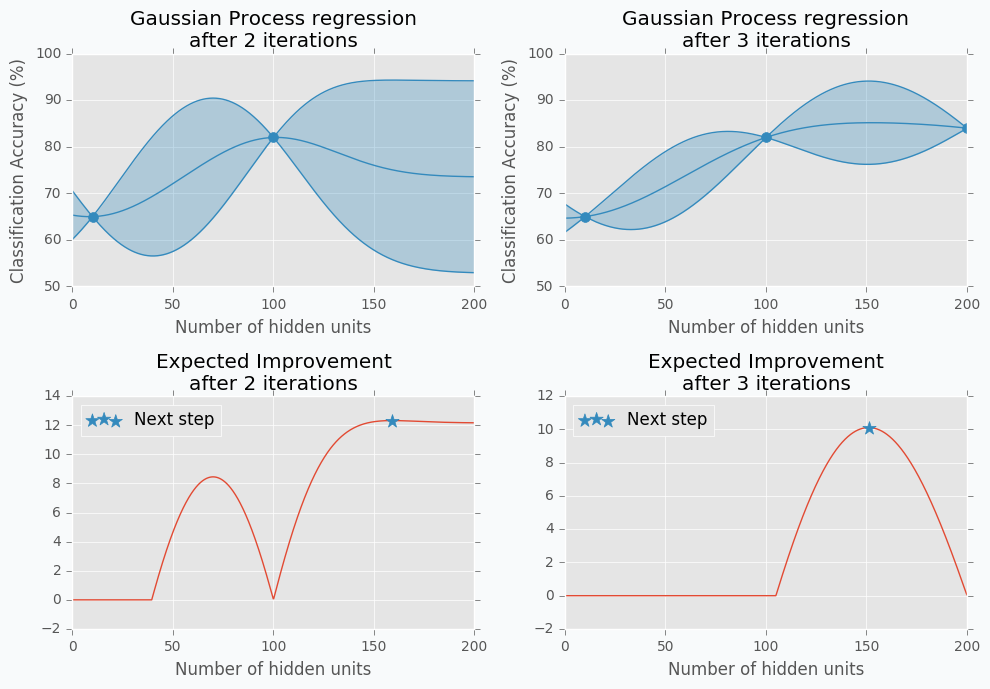



The following shows three popular activation functions and their Python codes.

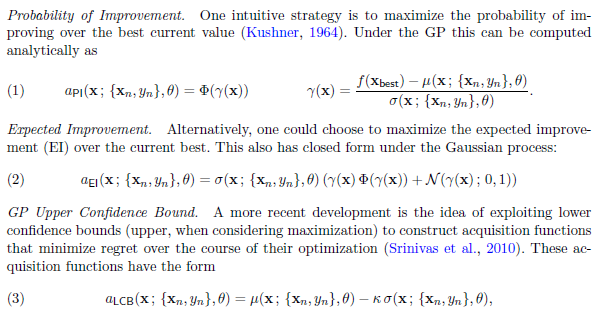

The Python codes for constructing the activation functions are the following:

```Python
from scipy.stats import norm

def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=1.0):
    return mu_x + kappa * sigma_x
```

Here we apply gaussian process to mnist dataset classification. First, we define a function that trains the neural network and return prediction error.

In [1]:
from neupy import algorithms, layers

def train_network(n_hidden, x_train, x_test, y_train, y_test):
    network = algorithms.Momentum(
    [
        layers.Input(64),
        layers.Relu(n_hidden),
        layers.Softmax(10),
    ],
    
    # Randomly shuffle dataset before each training epoch
    shuffle_data = True,
        
    # Do not show training progress in output
    verbose = False,
    
    step = 0.001,
    batch_size = 128,
    error = 'categorical_crossentropy',
    )
    network.train(x_train, y_train, epochs = 100)
    
    # Calculates categorical cross-entropy error between
    # predicted value for x_test and y_test value
    return network.prediction_error(x_test, y_test)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
f:\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Then we import digits from scikit-learn.

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from neupy import environment

#  Set up the same seed value for the NumPy and python random module to make your code reproducible
environment.reproducible()

mnist = datasets.load_digits()
n_samples = mnist.target.size
n_classes = 10

# One-hot encoder
target = np.zeros((n_samples, n_classes))
target[np.arange(n_samples), mnist.target] = 1

x_train, x_test, y_train, y_test = train_test_split(
    mnist.data, target, train_size=0.7
)

And for the last step, we need to define parameter selection procedure. In the first part, we need to define a function that performs Gaussian Process regression and returns mean and standard deviation of the prediction for the specified input vector.

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess

def vector_2d(array):
    return np.array(array).reshape((-1,1))

def gaussian_process(x_train, y_train, x_test):
    x_train = vector_2d(x_train)
    y_train = vector_2d(y_train)
    x_test = vector_2d(x_test)
    
    # train gaussian process
    # theta0=: The starting point for the maximum likelihood estimation of the best set of parameters
    # thetaL: Lower bound on the autocorrelation parameters for maximum likelihood estimation.
    # thetaU: Upper bound on the autocorrelation parameters for maximum likelihood estimation.
    gp = GaussianProcess(corr = 'squared_exponential', theta0 = 1e-1, thetaL = 1e-3, thetaU = 1)
    gp.fit(x_train,y_train)
    
    # Get mean and standard deviation for each possible
    # number of hidden units
    y_mean, y_var = gp.predict(x_test, eval_MSE=True)
    y_std = np.sqrt(vector_2d(y_var))

    return y_mean, y_std

Next we need to define expected improvement(EI) and find out next optimal step.

In [2]:
def next_parameter_by_ei(y_min, y_mean, y_std, x_choices):
    # Calculate expecte improvement from 95% confidence interval
    expected_improvement = y_min - (y_mean - 1.96 * y_std) # The expected_improvement here is a numpy array(np.array())
    expected_improvement[expected_improvement < 0] = 0

    max_index = expected_improvement.argmax() # Find the index with maximum expected improvement
    # Select next choice
    next_parameter = x_choices[max_index]

    return next_parameter

In [41]:
import random

def hyperparam_selection(func, n_hidden_range, func_args = None, n_iter = 20): # func here means your neural network
    if func_args == None:
        func_args = []
        
    scores = []
    parameters = []
    
    min_n_hidden, max_n_hidden = n_hidden_range
    n_hidden_choices = np.arange(min_n_hidden, max_n_hidden + 1)
    
    # To be able to perform gaussian process we need to
    # have at least 2 samples.
    n_hidden = random.randint(min_n_hidden, max_n_hidden)
    score = func(n_hidden, *func_args)
    
    parameters.append(n_hidden)
    scores.append(score)
    
    n_hidden = random.randint(min_n_hidden, max_n_hidden)
    
    for iteration in range(2, n_iter + 1):
        score = func(n_hidden, *func_args)
        
        parameters.append(n_hidden)
        scores.append(score)
        
        y_min = min(score)
        y_mean, y_std = gaussian_process(parameters, scores, n_hidden_choices)
        n_hidden = next_parameter_by_ei(y_min, y_mean, y_std, n_hidden_choices)
        
        if y_min == 0 or n_hidden in parameters:
            # the expected improvement has been achieved
            break
            
    min_score_index = np.argmin(scores)
    return parameters[min_score_index]

In [ ]:
import random
from sklearn import datasets, model_selection
from neupy import algorithms, layers, environment, estimators
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt

def vector_2d(array):
    return np.array(array).reshape((-1, 1))
    
def hyperparam_selection(func, n_hidden_range, func_args=None, n_iter=20):
    if func_args is None:
        func_args = []

    scores = []
    parameters = []

    min_n_hidden, max_n_hidden = n_hidden_range
    n_hidden_choices = np.arange(min_n_hidden, max_n_hidden + 1)
    
    for iteration in range(1, n_iter + 1):
        if iteration in (1, 2): # This gives two inital points
            n_hidden = random.randint(min_n_hidden, max_n_hidden)

        print('-----------------------')
        print('Iteration #{}'.format(iteration))
        print("Number of hidden layers: {}".format(n_hidden))

        nnet, score = func(n_hidden, *func_args)

        print("Cross entropy score: {}".format(score))

        parameters.append(n_hidden)
        scores.append(score)

        # To be able to perfome gaussian process we need to
        # have at least 2 samples.
        if iteration < 2:
            continue

        x_train = vector_2d(parameters)
        y_train = vector_2d(scores)
        x_test = vector_2d(n_hidden_choices)

        # Train gaussian process
        gp = GaussianProcess(corr='squared_exponential',
                             theta0=1e-1, thetaL=1e-3, thetaU=1)
        gp.fit(x_train, y_train)

        # Get mean and standard deviation for each possible
        # number of hidden units
        y_mean, y_var = gp.predict(x_test, eval_MSE=True)
        y_std = np.sqrt(vector_2d(y_var))

        y_min = min(scores)

        # Calculate expecte improvement from 95% confidence interval
        expected_improvement = y_min - (y_mean - 1.96 * y_std)
        expected_improvement[expected_improvement < 0] = 0

        max_index = expected_improvement.argmax()
        # Select next choice based on expected improvement
        n_hidden = n_hidden_choices[max_index]
        
        # Build plots
        ax1 = plt.subplot2grid((n_iter, 2), (iteration - 1, 0))
        ax2 = plt.subplot2grid((n_iter, 2), (iteration - 1, 1))
        
        order = np.argsort(parameters)

        plot_gp_bounds(x_train, y_train, n_hidden_choices, y_mean, y_std, ax1)
        ax1.scatter(parameters[-1], scores[-1], marker='*', s=150,
                    color=colors[0], zorder=10, label='Last step')
        ax1.set_title("Gaussian Process\nafter {} iterations".format(iteration))
        ax1.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax1.set_xlabel("Number of hidden units")
        ax1.set_ylabel("Cross entropy\n(the smaller the better)")
        ax1.legend(loc='upper right')
        
        ax2.plot(n_hidden_choices, expected_improvement)
        ax2.scatter(n_hidden_choices[max_index], expected_improvement[max_index],
                    marker='*', s=150, color=colors[1], label='Next step', zorder=10)
        ax2.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax2.set_title("Expected Improvement\nafter {} iterations".format(iteration))
        ax2.set_xlabel("Number of hidden units")
        
        if n_hidden > 450:
            ax2.legend(loc='upper left')
        else:
            ax2.legend(loc='upper right')
        
        if y_min == 0 or n_hidden in parameters:
            print("Converged")
            break
            
    min_score_index = np.argmin(scores)
    return parameters[min_score_index]
    
def train_network(n_hidden, x_train, x_test, y_train, y_test):
    network = algorithms.Momentum(
        [
            layers.Input(64),
            layers.Relu(n_hidden),
            layers.Softmax(10),
        ],

        # Randomly shuffle dataset before each
        # training epoch.
        shuffle_data=True,
        
        # Do not show training progress in output
        verbose=False,

        step=0.001,
        batch_size=128,
        error='categorical_crossentropy',
    )
    network.train(x_train, y_train, x_test, y_test, epochs=100)

    # Calculates categorical cross-entropy error between
    # predicted value for x_test and y_test value
    return network, network.prediction_error(x_test, y_test)


environment.reproducible()
    
dataset = datasets.load_digits()
n_samples = dataset.target.size
n_classes = 10
target = np.zeros((n_samples, n_classes))
target[np.arange(n_samples), dataset.target] = 1

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dataset.data, target, train_size=0.9
)

fig = plt.figure(figsize=(12, 16))

best_n_hidden = hyperparam_selection(
    train_network,
    n_hidden_range=[50, 1000],
    func_args=[x_train, x_test, y_train, y_test],
    n_iter=6,
)

print("")
print("Best number of hidden units: {}".format(best_n_hidden))

plt.tight_layout()
saveas('hyperparam-selection-nn-hidden-units')

-----------------------
Iteration #1
Number of hidden layers: 914
Cross entropy score: 0.09049941957147165
-----------------------
Iteration #2
Number of hidden layers: 444
